In [1]:
#Regression
import numpy as np
import scipy.signal
import os
import h5py
import time
import pandas as pd
import struct
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image
from joblib import Parallel, delayed
import sklearn.metrics as skmet
import sklearn.linear_model as sklin


import scipy.ndimage
import sklearn.decomposition as skdec
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn import svm
from sklearn import neighbors

C:\Users\sarytky\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
##Bilinear interpolation

#def imbilinear(im,col,x,row,y):
#	#Takes bilinear interpotalion from image
#	#Starts from coordinates [y,x], ends at row,col
#	e = 1e-12
#	x1 = int(np.floor(x))
#	x2 = int(np.ceil(x))
#	y1 = int(np.floor(y))
#	y2 = int(np.ceil(y))
#	Q11 = im[y2:y2+row,x1:x1+col]
#	Q21 = im[y2:y2+row,x2:x2+col]
#	Q12 = im[y1:y1+row,x1:x1+col]
#	Q22 = im[y1:y1+row,x2:x2+col]
#	R1 = ((x2-x)/(x2-x1+e))*Q11+((x-x1)/(x2-x1+e))*Q21
#	R2 = ((x2-x)/(x2-x1+e))*Q12+((x-x1)/(x2-x1+e))*Q22
#	P = ((y2-y)/(y2-y1+e))*R1+((y-y1)/(y2-y1+e))*R2
#	return P

def imbilinear(im,col,x,row,y):
    #Takes bilinear interpotalion from image
    #Starts from coordinates [y,x], ends at row,col
    e = 1e-12
    x1 = int(x)
    x2 = int(np.ceil(x))
    y1 = int(y)
    y2 = int(np.ceil(y))
    Q11 = im[y1:y1+row,x1:x1+col]
    Q21 = im[y1:y1+row,x2:x2+col]
    Q12 = im[y2:y2+row,x1:x1+col]
    Q22 = im[y2:y2+row,x2:x2+col]
    R1 = ((x2-x)/(x2-x1+e))*Q11+((x-x1)/(x2-x1+e))*Q21
    R2 = ((x2-x)/(x2-x1+e))*Q12+((x-x1)/(x2-x1+e))*Q22
    P = ((y2-y)/(y2-y1+e))*R1+((y-y1)/(y2-y1+e))*R2
    return P

#Gaussian kernel
def Gauss2D(w,sigma):
    #Generates 2d gaussian kernel
    kernel = np.zeros((w,w))
    #Constant for centering
    r = (w-1)/2
    for ii in range(w):
        for jj in range(w):
            x = -((ii-r)**2+(jj-r)**2)/(2*sigma**2)
            kernel[ii,jj] = np.exp(x)
    #Normalizing the kernel
    kernel = 1/np.sum(kernel)*kernel
    return kernel

#LBP
def lbp(im,r,n):
    #Takes lbp from numpy array
    #Uses n neighbours from radius r

    #center pixels
    center = im[r:-r,r:-r]
    row,col = np.shape(center)
    #Differences	

    #Empty array for pattern
    pattern = np.zeros((row,col))

    #LBP
    pi = np.pi	
    for k in range(n):
        #print(k)
        diff = np.empty((x,y))
        theta = 0+k*(1*2*pi/n)
        x = r+r*np.cos(theta)
        y = r+r*np.sin(theta)		
        #Check if bilinear interpolation is needed
        if abs(x-round(x))<1e-06 and abs(y-round(y))<1e-06:
            x = int(round(x))
            y = int(round(y))
            P = im[y:y+row,x:x+col]	
        else:			
            P = imbilinear(im,col,x,row,y)
        #Difference between neighbour and center pixel		
        diff = P[0:y,0:x] - center
        pattern = pattern+(diff>=0)*2**(k*(diff>=0))	

        #Empty histogram
        hist = np.zeros((1,2**n))
        #Binning
        for k in range(2**n):
            hist[0,k] = np.sum(pattern==k)
        hist = 1/np.linalg.norm(hist)*hist
        return hist

#MRELBP
def MRELBP(im,N,R,r,w_c,w_r):
    #Takes Median Robust Extended Local Binary Pattern from image im
    #Uses N neighbours from radii R and r, R must be larger than r
    #Median filter uses kernel sizes w_c for center pixels, w_r[0] for larger radius and w_r[1]
    #for smaller radius	
    #Grayscale values are centered at their mean and scales with global standad deviation

    #Mean grayscale value and std
    muI = im.mean()
    stdI = im.std()

    #Centering and scaling with std
    I = (im-muI)/stdI

    #Median filtering
    Ic = scipy.signal.medfilt(I,w_c)	
    #Center pixels
    d = round(R+(w_r[0]-1)/2)
    Ic = Ic[d:-d,d:-d]
    #Subtracting the mean pixel value from center pixels
    Ic = Ic-Ic.mean()
    #Bining center pixels
    Chist = np.zeros((1,2))
    #Chist[0,0] = np.sum(Ic>=0)
    #Chist[0,1] = np.sum(Ic<0)	
    Chist[0,0] = np.sum(Ic>=-1e-06)
    Chist[0,1] = np.sum(Ic<-1e-06)	

    #Median filtered images for large and small radius
    IL = scipy.signal.medfilt(I,w_r[0])
    d1 = round((w_r[0]-1)/2)
    IL = IL[d1:-d1,d1:-d1]
    IS = scipy.signal.medfilt2d(I,w_r[1])
    d2 = round((w_r[1]-1)/2)
    IS = IS[d2:-d2,d2:-d2]

    #Neighbours
    pi = np.pi
    #Empty arrays for the neighbours
    row,col = np.shape(Ic)
    NL = np.zeros((row,col,N))
    NS = np.zeros((row,col,N))
    for k in range(N):
        #Angle to the neighbour
        theta = 0+k*(-1*2*pi/N)
        #Large neighbourhood
        x = R+R*np.cos(theta)
        y = R+R*np.sin(theta)
        if abs(x-round(x)) < 1e-06 and abs(y-round(y)) < 1e-06:
            x = int(round(x))
            y = int(round(y))
            P = IL[y:y+row,x:x+col]
        else:
            P = imbilinear(IL,col,x,row,y)
        NL[:,:,k] = P
        #Small neighbourhood
        #x = r+r*np.cos(theta)
        #y = r+r*np.sin(theta)
        x = R+r*np.cos(theta)
        y = R+r*np.sin(theta)        
        if abs(x-round(x)) < 1e-06 and abs(y-round(y)) < 1e-06:
            x = int(round(x))
            y = int(round(y))
            P = IS[y:y+row,x:x+col]
        else:
            P = imbilinear(IS,col,x,row,y)
        NS[:,:,k] = P
    #Thresholding

    #Thresholding radial neighbourhood
    NR = NL-NS

    #Subtraction of means
    #Large neighbourhood
    NLmu = NL.mean(axis=2)		
    #Small neighbouhood
    NSmu = NS.mean(axis=2)

    for k in range(N):
        NL[:,:,k] = NL[:,:,k]-NLmu
        NS[:,:,k] = NS[:,:,k]-NSmu	

    #Converting to binary images and taking the lbp values

    #Initialization of arrays
    lbpIL = np.zeros((row,col))
    lbpIS = np.zeros((row,col))
    lbpIR = np.zeros((row,col))

    for k in range(N):
        #lbpIL = lbpIL+(NL[:,:,k]>=0)*2**(k*(NL[:,:,k]>=0))
        #lbpIS = lbpIS+(NS[:,:,k]>=0)*2**(k*(NS[:,:,k]>=0))
        #lbpIR = lbpIR+(NR[:,:,k]>=0)*2**(k*(NR[:,:,k]>=0))
        lbpIL = lbpIL+(NL[:,:,k]>=-1e-06)*2**(k)#*(NL[:,:,k]>=0))
        lbpIS = lbpIS+(NS[:,:,k]>=-1e-06)*2**(k)#*(NS[:,:,k]>=0))
        lbpIR = lbpIR+(NR[:,:,k]>=-1e-06)*2**(k)#*(NR[:,:,k]>=0))        

    #Binning
    Lhist = np.zeros((1,2**N))
    Shist = np.zeros((1,2**N))
    Rhist = np.zeros((1,2**N))
    for k in range(2**N):
        Lhist[0,k] = np.sum(lbpIL==k)
        Shist[0,k] = np.sum(lbpIS==k)
        Rhist[0,k] = np.sum(lbpIR==k)

    #Chist = 1/np.linalg.norm(Chist)*Chist
    #Lhist = 1/np.linalg.norm(Lhist)*Lhist
    #Shist = 1/np.linalg.norm(Shist)*Shist
    #Rhist = 1/np.linalg.norm(Rhist)*Rhist
    return Chist,Lhist,Shist,Rhist

#Mapping	
def getmapping(N):
    #Defines rotation invariant uniform mapping for lbp of N neighbours	
    newMax = N + 2
    table = np.zeros((1,2**N))
    for k in range(2**N):
        #Binary representation of bin number
        binrep = np.binary_repr(k,N)
        #Convert string to list of digits
        i_bin = np.zeros((1,len(binrep)))
        for ii in range(len(binrep)):
            i_bin[0,ii] = int(float(binrep[ii]))
        #Rotation
        j_bin = np.roll(i_bin,-1)
        #uniformity
        numt = np.sum(i_bin!=j_bin)		
        #Binning
        if numt <= 2:
            b = np.binary_repr(k,N)
            c=0
            for ii in range(len(b)):
                c = c+int(float(b[ii]))
            table[0,k] = c
        else:
            table[0,k] = N+1
    #num = newMax
    return table

#Apply mapping to lbp
def maplbp(bin,mapping):
    #Applies mapping to lbp bin
    #Number of bins in output
    N = int(np.max(mapping))
    #Empty array
    outbin = np.zeros((1,N+1))
    for k in range(N+1):
        #RIU indices
        M = mapping==k
        #Extract indices from original bin to new bin
        outbin[0,k] = np.sum(M*bin)
    return outbin

#Scikit PCA
def ScikitPCA(features,ncomp):
    pca = skdec.PCA(n_components=ncomp)
    score = pca.fit(features.T).transform(features.T)
    return score

#Principal component analysis
def PCA(features,ncomp):	
    #Feature dimension, x=num variables,N=num observations
    x,N = np.shape(features)		
    #Mean feature
    mean_f = np.mean(features,axis=1)
    #Centering
    centrd = np.zeros((x,N))
    for k in range(N):
        centrd[:,k] = features[:,k]-mean_f

    #PCs from covariance matrix if N>=x, svd otherwise
    if x<=N:
        #Covariance matrix
        Cov = np.zeros((x,x))
        f = np.zeros((x,1))
        for k in range(N):		
            f[:,0] = centrd[:,k]
            Cov = Cov+1/N*np.matmul(f,f.T)

        #Eigen values
        E,V = np.linalg.eig(Cov)		
        #Sort eigenvalues and vectors to descending order
        idx = np.argsort(E)[::-1]
        V = np.matrix(V[:,idx])
        E = E[idx]

        for k in range(ncomp):						
            s = np.matmul(V[:,k].T,centrd).T			
            try:
                score = np.concatenate((score,s),axis=1)
            except NameError:
                score = s
            p = V[:,k]
            try:
                pcomp = np.concatenate((pcomp,p),axis=1)
            except NameError:
                pcomp = p
    else:
        #PCA with SVD
        u,s,v = np.linalg.svd(centrd,compute_uv=1)
        pcomp = v[:,:ncomp]
        score = np.matmul(u,s).T[:,1:ncomp]		
    return pcomp,score

#Adaptive grayscale centering
def AGCentering(im,w):
    #Takes mean value in the window and subtracts it from the pixels within the window
    #Scales grayscale values to range [0,1]
    #w must be odd

    #Image size
    row,col = np.shape(im)
    #Empty image for output
    new_im = np.zeros((row,col))
    r = int((w-1)/2)
    for ii in range(row-2*r):
        for jj in range(col-2*r):
            y = r+1+ii			
            x = r+1+jj			
            new_im[y-r:y+r,x-r:x+r] = im[y-r:y+r,x-r:x+r]-np.mean(im[y-r:y+r,x-r:x+r])

    #Scales grayscale values to range[0 1]
    Gmax = np.max(new_im)
    Gmin = np.min(new_im)
    new_im = (new_im-Gmin)/(Gmax-Gmin)
    return new_im

#Local grayscale normalization normalization
def localnorm(im,w,sigma):
    #Centers grayscales with Gaussian weighted mean
    #Gaussian kernel	
    kernel = Gauss2D(w,sigma)
    #Blurring
    blurred = scipy.ndimage.convolve(im,kernel)
    #Normalizing with the blurred image
    new_im = im-blurred
    return new_im

#Local grayscale standardization
def localstandard(im,w1,w2,sigma1,sigma2):
    #Centers grayscales with Gaussian weighted mean
    #Gaussian kernels
    kernel1 = Gauss2D(w1,sigma1)
    kernel2 = Gauss2D(w2,sigma2)		
    #Blurring
    blurred1 = scipy.ndimage.convolve(im,kernel1)
    blurred2 = scipy.ndimage.convolve(im,kernel2)
    #Centering grayscale values
    centered = im-blurred1
    #Standardization
    std = (scipy.ndimage.convolve(centered**2,kernel2))**0.5
    new_im = centered/(std+1e-09)
    return new_im

#Subimage generation
def subimage(im,w,num):
    #Splits the image in num*num subimage of size 2w x 2w
    #Image size
    row,col = np.shape(im)
    imageset = np.zeros((2*w,2*w,num**2))
    #Image counter
    c = 0
    for ky in range(num):
        for kx in range(num):
            stepx = int((col-2*w)/(num-1))
            x1 = kx*stepx
            x2 = x1+2*w
            stepy = int((row-2*w)/(num-1))
            y1 = ky*stepy
            y2 = y1+2*w
            imageset[:,:,c] = im[y1:y2,x1:x2]
            c=c+1
    return imageset

#Regression
def regress(features,score):
    pred = []
    #Leave one out split
    loo = LeaveOneOut()	
    for trainidx, testidx in loo.split(features):
        #Indices
        X_train, X_test = features[trainidx], features[testidx]
        X_test -= X_train.mean(0)
        X_train -= X_train.mean(0)

        Y_train, Y_test = score[trainidx], score[testidx]		
        #Linear regression		
        regr = sklin.Ridge(alpha=1)
        regr.fit(X_train,Y_train)
        #Predicted score		
        pred.append(regr.predict(X_test))

    return np.array(pred)


#Logistic regression
def logreg(features,score):
    pred = []
    #Leave one out split
    loo = LeaveOneOut()	
    for trainidx, testidx in loo.split(features):
        #Indices
        X_train, X_test = features[trainidx], features[testidx]
        X_test -= X_train.mean(0)
        X_train -= X_train.mean(0)

        Y_train, Y_test = score[trainidx], score[testidx]		
        #Linear regression
        regr = sklin.LogisticRegression(solver='newton-cg',max_iter=1000)
        regr.fit(X_train,Y_train)
        #Predicted score
        P = regr.predict_proba(X_test)
        pred.append(P)

    pred = np.array(pred)
    pred = pred[:,:,1]
    return pred.flatten()
#Linear regression with LOO and KFOLD
def KFregress(features,score,fold):
    row,col = np.shape(features)
    fmean = np.mean(features,axis=1)
    for k in range(col):
        features[:,k] = features[:,k] - fmean.T
    pred = np.zeros((row,1))
    #Leave one out split
    loo = LeaveOneOut()	
    for trainidx, testidx in loo.split(features):
        #Indices
        X_train, X_test = features[trainidx], features[testidx]
        Y_train, Y_test = score[trainidx], score[testidx]
        #KFold split
        kpred = np.zeros((int(len(X_train)/fold),1))
        kf = KFold(n_splits = fold)
        c=0
        for ktrain,ktest in kf.split(X_train):
            X_Ktrain = X_train[ktrain]
            Y_Ktrain = Y_train[ktrain]
            #Linear regression
            regr = sklin.LinearRegression()
            regr.fit(X_Ktrain,Y_Ktrain)
            #Predicted score		
            kpred[c,0] = regr.predict(X_test)
            c=c+1
        pred[testidx,0] = np.mean(kpred,axis=0)
    return pred

'''
#LDA
def LDA(features,score):	
    row,col = np.shape(features)
    fmean = np.mean(features,axis=1)
    for k in range(col):
        features[:,k] = features[:,k] - fmean.T
    pred = np.zeros((row,1))
    #Leave one out split
    loo = LeaveOneOut()	
    for trainidx, testidx in loo.split(features):
        #Indices
        X_train, X_test = features[trainidx], features[testidx]
        Y_train, Y_test = score[trainidx], score[testidx]
        clf = LinearDiscriminantAnalysis()
        clf.fit(X_train,Y_train)
        pred[testidx,0] = clf.predict(X_test)
    return pred
'''

#Random forest
def RF(features,score,trees,d):
    score = np.ravel(score)
    row,col = np.shape(features)	
    pred = np.zeros((row,1))
    #Leaveone out split
    loo = LeaveOneOut()
    for trainidx,testidx in loo.split(features):
    #Indices
        X_train, X_test = features[trainidx], features[testidx]
        Y_train, Y_test = score[trainidx], score[testidx]		
        #Random Forest
        rf = RandomForestClassifier(n_estimators=trees,n_jobs = 4,max_depth=d,random_state=42)
        rf.fit(X_train,Y_train)
        #Prediction
        pred[testidx,0] = rf.predict(X_test)
    return pred

def augregression(testf,features,score):
    pred = []
    #Leave one out split	
    N = len(features[:,0])/len(testf[:,0])
    for k in range(len(testf[:,0])):
        #Indices and features
        X_test = testf[k,:]
        X_test = X_test.reshape(1,-1)
        idx = np.linspace(0,N-1,N)+k*N
        X_train = features
        X_train = np.delete(X_train,idx,axis=0)
        #Subtraction of mean
        X_train -= X_train.mean(0)
        X_test -= X_train.mean(0)
        Y_train = score
        Y_train = np.delete(Y_train,idx)				
        #Linear regression
        regr = sklin.Ridge(alpha=1)
        regr.fit(X_train,Y_train)
        #Predicted score		
        pred.append(regr.predict(X_test))

    return np.array(pred)

def augRF(testf,features,score,trees,d):
    pred = []
    #Leave one out split
    N = len(features[:,0])/len(testf[:,0])	
    for k in range(len(testf[:,0])):
        #Indices and features
        X_test = testf[k,:]
        X_test = X_test.reshape(1,-1)		
        idx = np.linspace(0,N-1,N)+k*N
        X_train = features
        X_train = np.delete(X_train,idx,axis=0)		
        Y_train = score
        Y_train = np.delete(Y_train,idx)				
        #Random forest regression
        rf = RandomForestClassifier(n_estimators=trees,n_jobs = 4,max_depth=d,random_state=42)
        rf.fit(X_train,Y_train)
        #Predicted score		
        pred.append(rf.predict(X_test))

    return np.array(pred)

def SVM(features,score):
    score = np.ravel(score)
    row,col = np.shape(features)	
    pred = np.zeros((row,1))
    #Leaveone out split
    loo = LeaveOneOut()
    for trainidx,testidx in loo.split(features):
    #Indices
        X_train, X_test = features[trainidx], features[testidx]
        Y_train, Y_test = score[trainidx], score[testidx]		
        #Random Forest
        clf = svm.SVC(random_state=42)
        clf.fit(X_train,Y_train)
        #Prediction
        pred[testidx,0] = clf.predict(X_test)
    return pred

def KNN(features,score):
    score = np.ravel(score)
    row,col = np.shape(features)	
    pred = np.zeros((row,1))
    #Leaveone out split
    loo = LeaveOneOut()
    for trainidx,testidx in loo.split(features):
    #Indices
        X_train, X_test = features[trainidx], features[testidx]
        Y_train, Y_test = score[trainidx], score[testidx]		
        #Random Forest
        clf = neighbors.KNeighborsRegressor(n_neighbors=5,weights='distance')
        clf.fit(X_train,Y_train)
        #Prediction
        pred[testidx,0] = clf.predict(X_test)
    return pred

def LDA(features,score):
    score = np.ravel(score)
    row,col = np.shape(features)	
    pred = np.zeros((row,1))
    #Leaveone out split
    loo = LeaveOneOut()
    for trainidx,testidx in loo.split(features):
    #Indices
        X_train, X_test = features[trainidx], features[testidx]
        Y_train, Y_test = score[trainidx], score[testidx]		
        #Random Forest
        clf = LinearDiscriminantAnalysis()
        clf.fit(X_train,Y_train)
        #Prediction
        pred[testidx,0] = clf.predict(X_test)
    return pred
def load_and_f(path,files):
    #Mapping for lbp
    mapping = getmapping(8)
    for k in range(len(files)):
        #Load file
        file = os.path.join(path,files[k])
        try:
            file = sio.loadmat(file)
            Mz = file['Mz']
            sz = file['sz']			
        except NotImplementedError:
            file = h5py.File(file)
            Mz = file['Mz'][()]
            sz = file['sz'][()]			

        #images

        #Combine mean and sd images
        image = Mz+sz
        #Grayscale normalization
        image = localstandard(image,23,5,5,1)
        #image = image[20:-20,20:-20]
        #Feature extraction
        dict = {'R':9,'r':3,'wc':5,'wr':(5,5)}		
        f1,f2,f3,f4 = MRELBP(image,8,dict['R'],dict['r'],dict['wc'],dict['wr'])

        #Normalization and mapping of the features f2(large neighbourhood lbp) and f4(radial lbp)

        f2 = maplbp(f2,mapping)
        f3 = maplbp(f3,mapping)
        f4 = maplbp(f4,mapping)
        #f1 = 1/np.linalg.norm(f1)*f1
        #f2 = 1/np.linalg.norm(f2)*f2
        #f3 = 1/np.linalg.norm(f3)*f3
        #f4 = 1/np.linalg.norm(f4)*f4

        #Concatenate features
        f = np.concatenate((f1.T,f2.T,f3.T,f4.T),axis=0)
        try:
            features = np.concatenate((features,f),axis=1)
        except NameError:
            features = f

    return features

def parallel_f(path,files,n_jobs): 
    parallelizer = Parallel(n_jobs=n_jobs)
    nlist = []
    N = int(len(files)/n_jobs)
    for k in range(n_jobs):
        nlist.append(files[k*N:(k+1)*N])

    iterator = ( delayed(load_and_f)(path,nfiles)
                for nfiles in nlist )
    result = parallelizer(iterator)
    features = np.hstack(result)
    return features, result

def loadbinary(path):
    bytesarray = np.fromfile(path, dtype=np.int32) # read everything as int32
    w = bytesarray[0]
    l = int((bytesarray.size - 1) / w)
    with open(path, "rb") as f: # open to read binary file
        f.seek(4) # skip first integer (width)
        features = np.zeros((w,l))
        for i in range(w):
            for j in range(l):
                features[i, j] = struct.unpack('<i', f.read(4))[0]  # when reading byte by byte (struct), 
                                                                #data type can be defined with every byte
        return features

Subtracted features
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Sum of differences
0.0

Relative difference
0.0

Sum of PCA differences
0.0

Relative PCA difference
0.0

Sample, grade, prediction
13_R3L_topo.mat 2 [1.76744728]
13_R6TL_topo.mat 2 [2.31269611]
14_R3L_topo.mat 0 [0.66091691]
14_R6LT_topo.mat 1 [0.61821769]
15_L3L_topo.mat 2 [2.29196118]
15_L6TL_topo.mat 3 [2.36039163]
20_R2M_topo.mat 2 [1.52992126]
20_R6TM_topo.mat 2 [2.88013238]
21_L3L_topo.mat 0 [0.]
21_L6LT_topo.mat 2 [1.16689263]
22_L3L_topo.mat 1 [0.]
22_L6TL_topo.mat 1 [1.56476343]
23_R3L_topo.mat 1 [0.79855628]
23_R6LT_topo.mat 3 [1.39546457]
24_R3L_topo.mat 2 [1.6474638]
24_R6LT_topo.mat 2 [1.70275857]
25_L3L_topo.mat 1 [1.4206491]
25_L6TL_topo.mat 3 [2.12305923]
26_L3L_topo.mat 2 [2.64917495]
26_L6LT_topo.mat 1 [0.64181763]
27R3M_topo.mat 1 [0.46569562]
27R6T_topo.mat 2 [2.09468308]
28_L3L_topo.mat 0 [

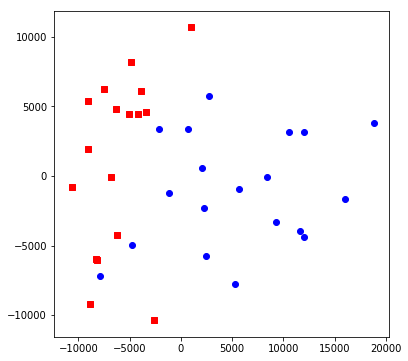

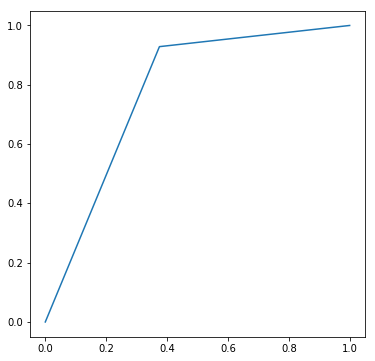

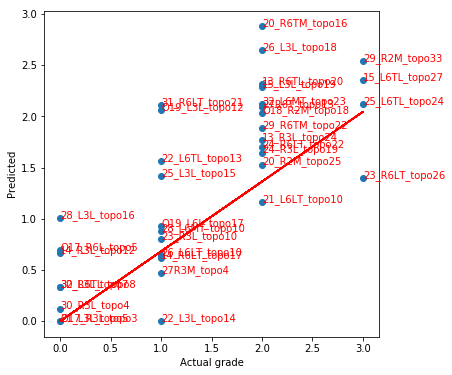

"\n#Save everything to excel file\nData = np.concatenate((g.flatten,pred1.flatten(),pred2.flatten()))\ndf1 = pd.DataFrame(Data)\nwriter = pd.ExcelWriter(r'c:\\users\\jfrondel\\desktop\\output.xlsx')\ndf1.to_excel(writer)\nwriter.save()\n"

In [4]:
#Start time
start_time = time.time()
#Samples
impath = r'V:\Tuomas\PTASurfaceImages'
filelist = os.listdir(impath)
filelist.sort()

##Grades from excel file
#grades = pd.ExcelFile(r'C:\Users\jfrondel\Desktop\Work\Koodit\BOFKoodia\Segmentation\PTAgreiditjanaytteet.xls')
#grades = pd.read_excel(grades)
#grades = pd.DataFrame.as_matrix(grades)
#grades = grades[:,2:3]
#g = grades[:,0].astype('int')

# Load grades to array
grades = pd.read_excel(r'C:\Users\sarytky\Desktop\trials' + r'\PTAgreiditjanaytteet.xls', 'Sheet1')
grades = pd.DataFrame(grades).values
g = grades[:,2].astype('int')
grades = grades[:,1:2]

#Features
features,result = parallel_f(impath,filelist,4)
features_csharp = loadbinary(r'C:\Users\sarytky\Desktop\trials' + r'\features.dat')
print('Subtracted features')
print(features_csharp-features)
print('\nSum of differences')
print(np.sum(np.absolute(features_csharp-features)))
print('\nRelative difference')
print(np.sum(np.absolute(features_csharp-features))/np.sum(features))

#PCA
score = ScikitPCA(features,10)
score_csharp = ScikitPCA(features_csharp,10)
print('\nSum of PCA differences')
print(np.sum(np.absolute(score_csharp-score)))
print('\nRelative PCA difference')
print(np.sum(np.absolute(score_csharp-score))/np.sum(np.absolute(score)))
#print(score.shape)

#Regression
pred1 = regress(score,g)
pred2 = logreg(score,g>0)
#pred2 = logreg(features.T,g>0)
for p in range(len(pred1)):
    if pred1[p]<0:
        pred1[p] = 0
    if pred1[p] > 3:
        pred1[p]=3

#Plotting the prediction
a = g
b = np.round(pred1).astype('int')	

#Plotting PCA scores
x = score[:,0]
y = score[:,1]
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(score[g<2,0],score[g<2,1],marker='o',color='b',label='Normal')	
ax1.scatter(score[g>1,0],score[g>1,1],marker='s',color='r',label='OA')

#for k in range(len(grades[:,0])):
#    txt = filelist[k]
#    txt = txt[0:-4]
#    txt = txt+str(grades[k,0])		
#    if grades[k,0] >= 2:
#        ax1.scatter(x[k],y[k],marker='s',color='r')
#        #ax1.annotate(txt,xy=(x[k],y[k]),color='r')
#    else:
#        ax1.scatter(x[k],y[k],marker='o',color='b')
#        #ax1.annotate(txt,xy=(x[k],y[k]),color='b')	
print('\nSample, grade, prediction')
for k in range(len(filelist)):
    print(filelist[k],a[k],pred1[k])#,pred3[k])

C1 = skmet.confusion_matrix(a,b)
MSE1 = skmet.mean_squared_error(a,pred1)
fpr, tpr, thresholds = skmet.roc_curve(a>0, np.round(pred1)>0, pos_label=1)
AUC1 = skmet.auc(fpr,tpr)	
AUC1 = skmet.roc_auc_score(a>0,pred2)
t = time.time()-start_time
m, b = np.polyfit(a, pred1.flatten(), 1)
R2 = skmet.r2_score(a,pred1.flatten())

# Area under curve
fig0  = plt.figure(figsize=(6,6))
ax0 = fig0.add_subplot(111)
ax0.plot(fpr,tpr)

print('Confusion matrix')
print(C1)
print('Mean squared error, Area under curve')
print(MSE1,AUC1)#,MSE2,MSE3,MSE4)
print("-- %s seconds --" % t)
print('R2 score')
print(R2)

#print('Prediction: ')
#print(pred1)
#print('Difference:')
#print(pred1.flatten() - g)
print('Sum of differences')
print(np.sum(np.abs(pred1.flatten() - g)))

# Grade vs. predicted
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)
ax2.scatter(a,pred1.flatten())
ax2.plot(a,m*a,'-',color='r')
ax2.set_xlabel('Actual grade')
ax2.set_ylabel('Predicted')
for k in range(len(grades[:,0])):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(grades[k,0])
    ax2.annotate(txt,xy=(a[k],pred1[k]),color='r')
plt.show()

#Save everything
dict = {'g':g,'pred1':pred1,'pred2':pred2}
sio.savemat(r'C:\Users\sarytky\Desktop\trials\regressresults_ref.mat',dict)
r'''
#Save everything to excel file
Data = np.concatenate((g.flatten,pred1.flatten(),pred2.flatten()))
df1 = pd.DataFrame(Data)
writer = pd.ExcelWriter(r'c:\users\jfrondel\desktop\output.xlsx')
df1.to_excel(writer)
writer.save()
'''

In [12]:
#Regression
import numpy as np
import scipy.signal
import os
import h5py
import time
import pandas as pd
import scipy.io as sio
#import matplotlib.pyplot as plt
from PIL import Image
from joblib import Parallel, delayed
import sklearn.metrics as skmet
import sklearn.linear_model as sklin

import ImageProcessing as IP

def load_and_f(path,files):
    #Mapping for lbp
    mapping = IP.getmapping(8)
    for k in range(len(files)):
        #Load file
        file = os.path.join(path,files[k])
        try:
            file = sio.loadmat(file)
            Mz = file['Mz']
            sz = file['sz']			
        except NotImplementedError:
            file = h5py.File(file)
            Mz = file['Mz'][()]
            sz = file['sz'][()]			

        #images

        #Combine mean and sd images
        image = Mz+sz
        #Grayscale normalization
        image = IP.localstandard(image,23,5,5,1)
        #image = image[20:-20,20:-20]
        #Feature extraction
        dict = {'R':9,'r':3,'wc':5,'wr':(5,5)}		
        f1,f2,f3,f4 = IP.MRELBP(image,8,dict['R'],dict['r'],dict['wc'],dict['wr'])

        #Normalization and mapping of the features f2(large neighbourhood lbp) and f4(radial lbp)

        #f1 = 1/np.linalg.norm(f1)*f1
        f2 = IP.maplbp(f2,mapping)
        #f2 = 1/np.linalg.norm(f2)*f2
        f3 = IP.maplbp(f3,mapping)
        #f3 = 1/np.linalg.norm(f3)*f3
        f4 = IP.maplbp(f4,mapping)
        #f4 = 1/np.linalg.norm(f4)*f4

        #Concatenate features
        f = np.concatenate((f1.T,f2.T,f3.T,f4.T),axis=0)
        try:
            features = np.concatenate((features,f),axis=1)
        except NameError:
            features = f

    return features

def parallel_f(path,files,n_jobs): 
    parallelizer = Parallel(n_jobs=n_jobs)
    nlist = []
    N = int(len(files)/n_jobs)
    for k in range(n_jobs):
        nlist.append(files[k*N:(k+1)*N])

    iterator = ( delayed(load_and_f)(path,nfiles)
                for nfiles in nlist )
    result = parallelizer(iterator)
    features = np.hstack(result)
    return features, result

In [ ]:
import matplotlib.pyplot as plt
#Start time
start_time = time.time()
#Samples
impath = r'V:\Tuomas\PTASurfaceImages'
savepath = r'Z:\3DHistoData\Grading'
filelist = os.listdir(impath)
filelist.sort()
for k in range(len(filelist)):
    print(str(k) + ' ' + filelist[k])
#Grades from excel file

grades = pd.read_excel(r'C:\Users\sarytky\Desktop\trials' + r'\PTAgreiditjanaytteet.xls', 'Sheet1')
grades = pd.DataFrame(grades).values
g = grades[:,2].astype('int')
grades = grades[:,1:2]
#Features
features,result = parallel_f(impath,filelist,4)	

# Save features
writer = pd.ExcelWriter(savepath + r'\LBP_features_ref.xlsx')
df1 = pd.DataFrame(features)
df1.to_excel(writer, sheet_name='LBP_features')
writer.save()

(32, 36)
(36, 10)
13_R3L_topo.mat 2 [2.20272576]
13_R6TL_topo.mat 2 [2.71941988]
14_R3L_topo.mat 0 [0.42463038]
14_R6LT_topo.mat 1 [0.68053867]
15_L3L_topo.mat 2 [2.12174486]
15_L6TL_topo.mat 3 [2.01039814]
20_R2M_topo.mat 2 [1.66486992]
20_R6TM_topo.mat 2 [1.32678809]
21_L3L_topo.mat 0 [0.]
21_L6LT_topo.mat 2 [1.70819185]
22_L3L_topo.mat 1 [0.77905787]
22_L6TL_topo.mat 1 [1.18264901]
23_R3L_topo.mat 1 [1.05412665]
23_R6LT_topo.mat 3 [2.85720795]
24_R3L_topo.mat 2 [2.27531845]
24_R6LT_topo.mat 2 [1.85475073]
25_L3L_topo.mat 1 [0.54727746]
25_L6TL_topo.mat 3 [3.]
26_L3L_topo.mat 2 [2.78186389]
26_L6LT_topo.mat 1 [0.9852911]
27R3M_topo.mat 1 [0.92065901]
27R6T_topo.mat 2 [1.88964853]
28_L3L_topo.mat 0 [0.79328597]
28_L6MT_topo.mat 1 [0.67374149]
29_R2M_topo.mat 3 [2.80787318]
29_R6TM_topo.mat 2 [2.01718881]
30_R3L_topo.mat 0 [0.]
30_R6TL_topo.mat 0 [0.48782789]
31_R6LT_topo.mat 1 [1.26710009]
32_L3L_topo.mat 0 [0.08367094]
32_L6MT_topo.mat 2 [1.45269393]
O17_R3L_topo.mat 0 [0.62295462]
O

NameError: name 'm' is not defined

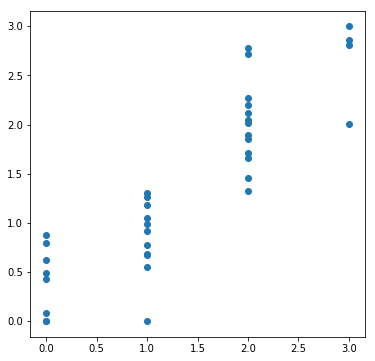

In [15]:
#PCA
print(features.shape)
score = IP.ScikitPCA(features,10)
print(score.shape)
pred1 = IP.regress(features.T,g)
pred2 = IP.logreg(features.T,g>0)
#pred2 = IP.logreg(features.T,g>0)
for p in range(len(pred1)):
    if pred1[p]<0:
        pred1[p] = 0
    if pred1[p] > 3:
        pred1[p]=3

#Plotting the prediction
a = g
b = np.round(pred1).astype('int')	

#Plotting
x = score[:,0]
y = score[:,1]
#fig = plt.figure(figsize=(6,6))
#plt.grid(True)
#ax1 = fig.add_subplot(111)
#ax1.scatter(score[g<2,0],score[g<2,1],marker='o',color='b',label='Normal')	
#ax1.scatter(score[g>1,0],score[g>1,1],marker='s',color='r',label='OA')

#for k in range(len(grades[:,0])):
#    txt = filelist[k]
#    txt = txt[0:-4]
#    txt = txt+str(grades[k,0])		
#    if grades[k,0] >= 2:
#        ax1.scatter(x[k],y[k],marker='s',color='r')
        #ax1.annotate(txt,xy=(x[k],y[k]),color='r')
#    else:
#        ax1.scatter(x[k],y[k],marker='o',color='b')
        #ax1.annotate(txt,xy=(x[k],y[k]),color='b')	

for k in range(len(filelist)):
    print(filelist[k],a[k],pred1[k])#,pred3[k])
C1 = skmet.confusion_matrix(a,b)

MSE1 = skmet.mean_squared_error(a,pred1)
fpr, tpr, thresholds = skmet.roc_curve(a>0, np.round(pred1)>0, pos_label=1)
AUC1 = skmet.auc(fpr,tpr)	
#fig0  = plt.figure(figsize=(6,6))
#ax0 = fig0.add_subplot(111)
#ax0.plot(fpr,tpr)
AUC1 = skmet.roc_auc_score(a>0,pred2)

print(C1)

print(MSE1,AUC1)#,MSE2,MSE3,MSE4)

t = time.time()-start_time
print("-- %s seconds --" % t)
#plt.legend()
#plt.show()


#m, b = np.polyfit(a, pred1.flatten(), 1)

R2 = skmet.r2_score(a,pred1.flatten())
print(R2)
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)
ax2.scatter(a,pred1.flatten())
ax2.plot(a,m*a,'-',color='r')
ax2.set_xlabel('Actual grade')
ax2.set_ylabel('Predicted')
for k in range(len(grades[:,0])):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(grades[k,0])
    ax2.annotate(txt,xy=(a[k],pred1[k]),color='r')
plt.show()

#Save everythin
#dict = {'g':g,'pred1':pred1,'pred2':pred2}
#sio.savemat(r'c:\users\jfrondel\desktop\regressresults.mat',dict)

#Save everything to excel file
#Data = np.concatenate((g.flatten,pred1.flatten(),pred2.flatten()))
#df1 = pd.DataFrame(Data)
#writer = pd.ExcelWriter(r'c:\users\jfrondel\desktop\output.xlsx')
#df1.to_excel(writer)
#writer.save()
    

In [ ]:
test = np.zeros((8,8))
test[0:4,0:4] = 1
test[4:8,0:4] = 3
test[0:4,4:8] = 2
test[4:8,4:8] = 4
print(test)
x = 1.25
y = 1.25
col = 6
row = 6
interpolated = imbilinear(test,col,x,row,y)
print(interpolated)

In [11]:
#Regression
pred1 = regress(score_csharp,g)
pred2 = logreg(score_csharp,g>0)
#pred2 = logreg(features.T,g>0)
for p in range(len(pred1)):
    if pred1[p]<0:
        pred1[p] = 0
    if pred1[p] > 3:
        pred1[p]=3

#Plotting the prediction
a = g
b = np.round(pred1).astype('int')	

#Plotting PCA scores
x = score_csharp[:,0]
y = score_csharp[:,1]
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(score_csharp[g<2,0],score_csharp[g<2,1],marker='o',color='b',label='Normal')	
ax1.scatter(score_csharp[g>1,0],score_csharp[g>1,1],marker='s',color='r',label='OA')

#for k in range(len(grades[:,0])):
#    txt = filelist[k]
#    txt = txt[0:-4]
#    txt = txt+str(grades[k,0])		
#    if grades[k,0] >= 2:
#        ax1.scatter(x[k],y[k],marker='s',color='r')
#        #ax1.annotate(txt,xy=(x[k],y[k]),color='r')
#    else:
#        ax1.scatter(x[k],y[k],marker='o',color='b')
#        #ax1.annotate(txt,xy=(x[k],y[k]),color='b')	
print('\nSample, grade, prediction')
for k in range(len(filelist)):
    print(filelist[k],a[k],pred1[k])#,pred3[k])

C1 = skmet.confusion_matrix(a,b)
MSE1 = skmet.mean_squared_error(a,pred1)
fpr, tpr, thresholds = skmet.roc_curve(a>0, np.round(pred1)>0, pos_label=1)
AUC1 = skmet.auc(fpr,tpr)	
AUC1 = skmet.roc_auc_score(a>0,pred2)
t = time.time()-start_time
m, b = np.polyfit(a, pred1.flatten(), 1)
R2 = skmet.r2_score(a,pred1.flatten())

# Area under curve
fig0  = plt.figure(figsize=(6,6))
ax0 = fig0.add_subplot(111)
ax0.plot(fpr,tpr)

print('Confusion matrix')
print(C1)
print('Mean squared error, Area under curve')
print(MSE1,AUC1)#,MSE2,MSE3,MSE4)
print("-- %s seconds --" % t)
print('R2 score')
print(R2)

# Grade vs. predicted
fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)
ax2.scatter(a,pred1.flatten())
ax2.plot(a,m*a,'-',color='r')
ax2.set_xlabel('Actual grade')
ax2.set_ylabel('Predicted')
for k in range(len(grades[:,0])):
    txt = filelist[k]
    txt = txt[0:-4]
    txt = txt+str(grades[k,0])
    ax2.annotate(txt,xy=(a[k],pred1[k]),color='r')
plt.show()

NameError: name 'regress' is not defined